Introduction
-

In this notebook, how to treat the temperature was studied. 

For clarification, there are two temperatures in Langevin dynamics, the temperture of the thermostat $T_{bath}$ (in our case, it is determined by the noise level), which is a constant, and the temperature $T_{kin}$ coming from the kinetic energy.

As Julian suggested, the temperature in the fluctuation-dissipation theorem ($\alpha = 2T \gamma$) is a variant which should be iterated during the molecule's motion. If it is true, then are there ways to sample the temperature:
1. Calculate $T_{kin}$ from the velocities of the last step.
2. Calculate $T_{kin}$ from the velocities of a certain time window, e.g., one period.
3. Calculate $T_{kin}$ from the velocities of all the time steps before.

Then the $T_{kin}$ will approach the $T_{bath}$ in a long term (so-called thermalization).
In some cases of the first two approaches, the dynamics become very unstable depending on the parameters (typically $\Delta$). I cannot draw a solid conclusion on when this happens, probably when $\Delta$ is large.

However, I studied some more literature and found most of them saying the temperature in the fluctuation-dissipation theorem should be a constant, i.e., $T_{bath}$ (M.Germana Paterlini, David M Ferguson, Constant temperature simulations using the Langevin equation with velocity Verlet integration, Chemical Physics, Volume 236, Issues 1–3, 1998, Pages 243-252). This argument is more convincing as that is what canonical ensemble defines (constant NVT). 

Since we do not know the temperture of the thermostat $T_{bath}$, the third way to calculate $T$ is more physical to me, as in each step, $T_{kin}$ gets closer and closer to $T_{bath}$. And this way seems give the best results based on the limited cases I calculated (It still takes several hours to run a long time dynamics on my laptop).

Now let us discuss the role of $\Delta$.

Although Luo, et al. ( Ye Luo, Andrea Zen, and Sandro Sorella, "Ab initio molecular dynamics with noisy forces: Validating the quantum Monte Carlo approach with benchmark calculations of molecular vibrational properties", J. Chem. Phys. 141, 194112 (2014)) argue that $\Delta$ should be no small than the time step, it is not applicable to our case.

The paper by Kavalur, et al. (Aditya Kavalur, Varun Guduguntla & Woo Kyun Kim (2020) Effects of Langevin friction and time steps in the molecular dynamics simulation of nanoindentation, Molecular Simulation, 46:12, 911-922) explicitly studied the effect of friction and time step. By frictionn, they mean the friction matrix $\gamma$, which can be scaled by $\Delta$ in our case.

Cited from Kavalur's paper -- "A very large Langevin friction coefficient leads to a Brownian motion whereas a very low friction coefficient may have difficulty in dissipating excessive heat within a limited simulation time." 

Anyway,the friction term is regarded as a thermostat driving the Langevin dynamics. It drives the particles to somewhere around the equilibrium and finally reproduce the phase space distribution $f(r, p)$ of atom positions (r) and momenta (p) according to the canonical
ensemble (fig. 8d in Sokolov), i.e.,
$$f(r, p) \propto exp\left[- \frac{H(r, p)}{k_{B}T}\right]$$

"Since Langevin thermostat is known to reproduce the equilibrium phase space distribution regardless of the magnitude of Langevin friction, any value may be chosen for equilibrium simulations." Therefore we need to choose $\Delta$ wisely. But its meaning is on numerics but not physics. Different choices of $\Delta$ should lead to the same distribution and same temperature as long as the system reaches equilibrium. Probably the three ways to iterate temperature should also lead to same results.

The point of Langevin dynamics is to recover the Boltzmann distribution $f(r, p)$. We need to fit the energy-distance relation with Morse potential and substitute it to the $H(r, p)$ in $f(r, p)$. Then by fitting the probability distribution of the distance between two atoms with $f(r, p)$, we can get the temperature, which is the $T_{bath}$. $T_{bath}$ should be equal to $T_{kin}$ when the equilibrium is achieved.

In [4]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

$\color{red}{\text{In this case, the temperature is iterated for every time step based on the average kinetic energy of all the iterations before. }}$ (The 3rd way in the introduction.)

The calculated temperature should approach to the $T_{bath}$ after a long term run. (script v1.3)

In [2]:
# Both the VQE and the force functions used qasm simulator
#delta = 0.1*dt
coords1 = np.loadtxt('coords_qasm_vqe_1.5ps_H2_full.txt')
momentum1 = np.loadtxt('momentum_qasm_vqe_1.5ps_H2_full.txt')
temperature1 = np.loadtxt('temperature_qasm_vqe_1.5ps_H2_full.txt')

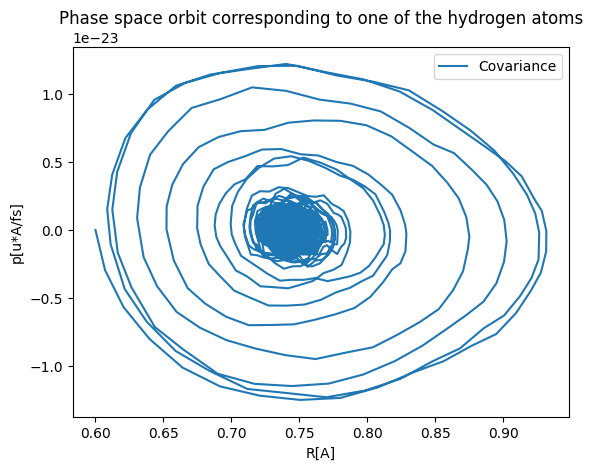

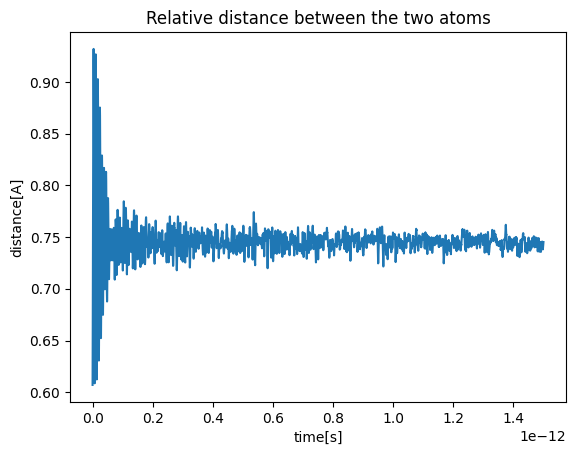

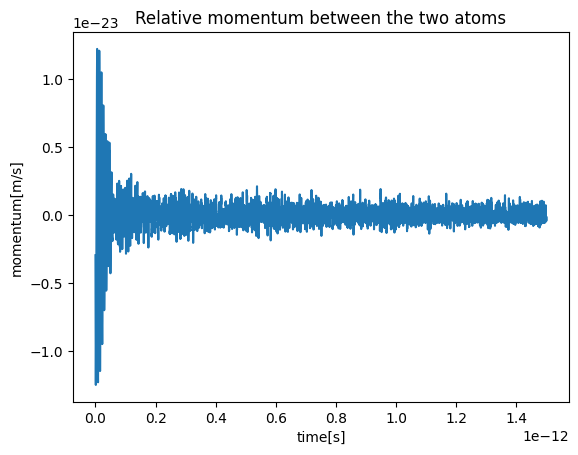

In [6]:
femto = 1.0e-15
dt = 0.2*femto
times1 = np.arange(0*femto, 1500.0*femto, dt)
coords_np1 = np.array(coords1)
momentum_np1 = np.array(momentum1)
dist1 = coords_np1[:,1]-coords_np1[:,0]
p1 = momentum_np1[:,0]

plt.plot(dist1, p1, label="Covariance")
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*A/fs]")
plt.legend()
plt.show()

plt.plot(times1, dist1[1:])
plt.title('Relative distance between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('distance[A]')
plt.show()

plt.plot(times1, p1[1:])
plt.title('Relative momentum between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('momentum[m/s]')
plt.show()

In [73]:
n_dof = 1
u = 1.67e-27
mass_0 = u
mass_1 = u
mass = np.array([mass_0, mass_1])
v_sample = momentum1[3000:]/mass # assume the equilibrium ia reached after 3000 steps
kin_eng = np.sum(v_sample**2*mass/2, axis=1)
k_B = 1.38065e-23
k_T = 2*np.sum(kin_eng)/np.size(kin_eng)/n_dof
print('T_kin:',k_T/k_B)

T_kin: 20.284054529331065


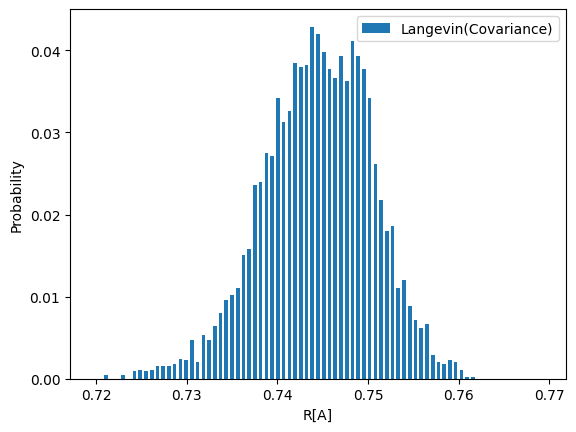

In [74]:
import pandas as pd
bins1 = np.linspace(0.72, 0.77,80)
prob1 = pd.cut(dist1[3000:],bins1)
langevin1 = pd.value_counts(prob1, normalize=True).sort_index()
distr_langevin1 = []
for value in langevin1:
    distr_langevin1.append(value)
    
width = 0.0004
plt.bar(np.array(bins1[:-1])-width/2, np.array(distr_langevin1),width=width, label="Langevin(Covariance)")
plt.xlabel("R[A]")
plt.ylabel("Probability")
plt.legend()
plt.show()

$\color{red}{\text{Fit the Morse potential,}}$
$$c\{exp[-2m(r-r_{eq})]-2exp[-m(r-r_{eq})]\}$$

In [104]:
#VQE qasm simulator, sampled 20 times
distances = np.arange(0.6, 0.9, 0.01)
vqe_potential = np.loadtxt('qasm_vqe_eng.txt')

In [77]:
vqe_mean = np.mean(vqe_potential, axis=0)
vqe_err = np.std(vqe_potential, axis=0)

In [78]:
def morse_potential(r, c, m, req):
    return c*(np.exp(-2*m*(r-req))-2*np.exp(-m*(r-req)))

In [80]:
poptmp, pcovmp = curve_fit(morse_potential, distances, vqe_mean)
vqe_pred = [morse_potential(i, poptmp[0], poptmp[1], poptmp[2]) for i in distances]

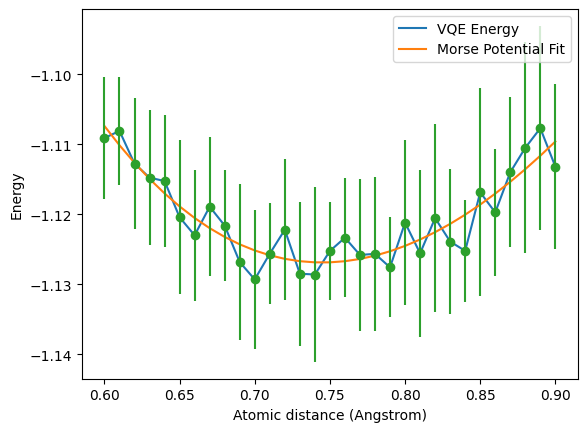

In [81]:
plt.plot(distances, vqe_mean, label="VQE Energy")
plt.plot(distances, vqe_pred, label="Morse Potential Fit")
plt.errorbar(distances, vqe_mean, yerr = vqe_err, fmt ='o')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [88]:
print('c: %f, m: %f, r_eq: %f' %(poptmp[0],poptmp[1], poptmp[2]))

c: 1.126879, m: 0.852803, r_eq: 0.744931


$\color{red}{\text{Fit the prob. distribution of distance between the two atoms to Boltzmann distribution}}$

In [89]:
Ha = 4.36e-18
c = poptmp[0] #Ha
m = poptmp[1] #angst^-1
req = poptmp[2] #angst
kb = k_B/Ha

def func(r, tem, amp):
    return amp*np.exp(-(c*(np.exp(-2*m*(r-req))-2*np.exp(-m*(r-req)))+c)/(kb*tem))

In [90]:
poptstat, pcovstat = curve_fit(func, bins[1:], distr_langevin)
distr_pred = [func(i, poptstat[0], poptstat[1]) for i in bins]

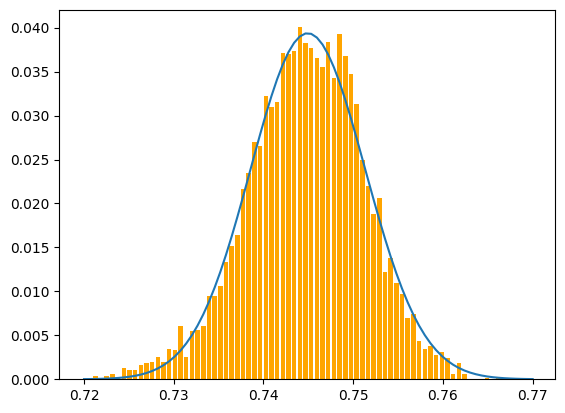

In [94]:
plt.bar(np.array(bins[:-1]), np.array(distr_langevin),width=0.0005, color='orange')
plt.plot(np.array(bins), np.array(distr_pred))
plt.show()

In [93]:
print('T_kin: %f; T_bath: %f'%(k_T/k_B, poptstat[0]))

T_kin: 20.284055; T_bath: 21.156339


We can see $T_{kin}$ and $T_{bath}$ agree well with each other. To be more rigourously, there should be a confidence interval. And another left problem is to determine the thermalization time so we can calculate $T_{kin}$ explicitly but not apploximate it by eyes...

However, comparing to Sokolv, our temperature is much lower. I cannot figure out why (it would be nice if we could ask him directly...). Maybe he also add some Gaussian white noise as mentioned in the paper, or maybe his $F_1$ and $F_2$ were calculated separately whereas $F_1 = -F_2$ in our case. Or probably there are some mistakes in my script. The noise seems to be much more weaker than his case.

As an attempt, the period of the oscillation are first calculated (~33*dt). Then the temperature is calculated for each iteration based on the kinetic energy of the previous one period.

Unfortunately I didn't save the data. The phase orbital is pretty ugly but the distribution looks very similar to the following case. (script v1.2)

$\color{red}{\text{The following corresponds to the first way to calculate the temperature.}}$ (The 1st way in the introduction, script v1.1)

In [95]:
#delta = 0.05*dt
#vqe: statevector; force:vqe
coords2 = np.loadtxt('coords_qasm_no_noise_2ps_H2_full_Iterated_T.txt')
momentum2 = np.loadtxt('momentum_qasm_no_noise_2ps_H2_full_Iterated_T.txt')
temperature2 = np.loadtxt('temperature_qasm_no_noise_2ps_H2_full_Iterated_T.txt')

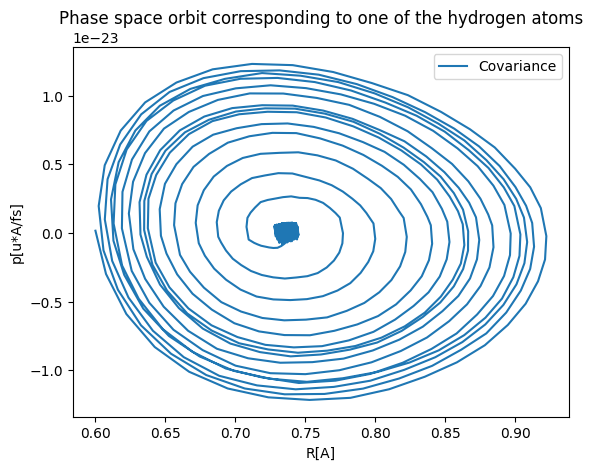

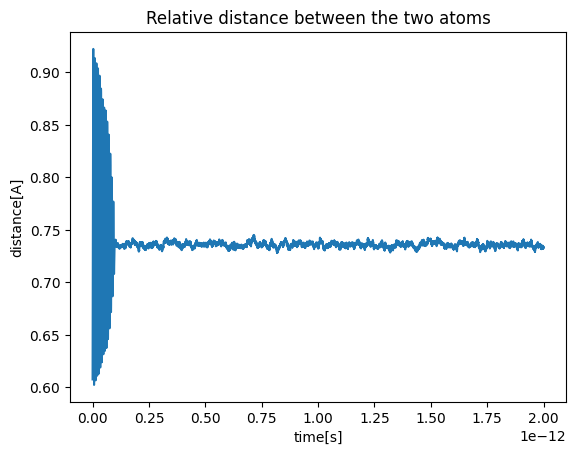

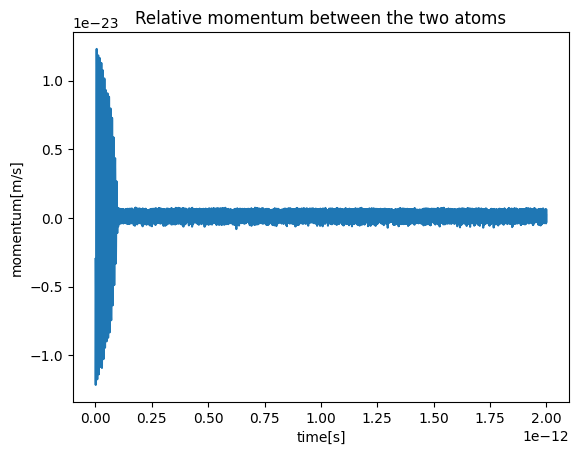

In [96]:
femto = 1.0e-15
dt = 0.2*femto
times2 = np.arange(0*femto, 2000.0*femto, dt)
coords_np2 = np.array(coords2)
momentum_np2 = np.array(momentum2)
dist2 = coords_np2[:,1]-coords_np2[:,0]
p2 = momentum_np2[:,0]

plt.plot(dist2, p2, label="Covariance")
plt.title('Phase space orbit corresponding to one of the hydrogen atoms')
plt.xlabel("R[A]")
plt.ylabel("p[u*A/fs]")
plt.legend()
plt.show()

plt.plot(times2, dist2[1:])
plt.title('Relative distance between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('distance[A]')
plt.show()

plt.plot(times2, p2[1:])
plt.title('Relative momentum between the two atoms')
plt.xlabel("time[s]")
plt.ylabel('momentum[m/s]')
plt.show()

In [140]:
v_sample = momentum2[3000:]/mass # assume the equilibrium ia reached after 3000 steps
kin_eng = np.sum(v_sample**2*mass/2, axis=1)
k_B = 1.38065e-23
k_T = 2*np.sum(kin_eng)/np.size(kin_eng)/n_dof
print('T_kin:',k_T/k_B)

T_kin: 10.817055087301668


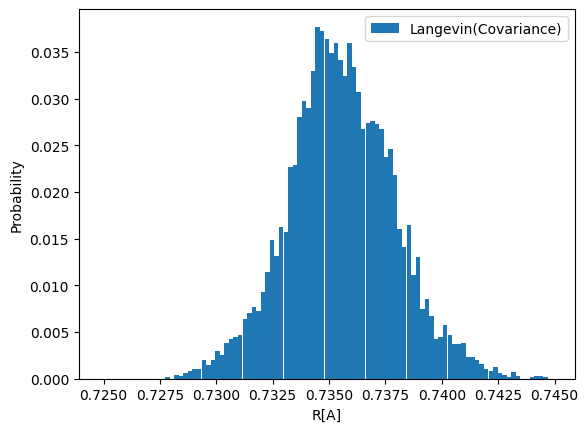

In [129]:
bins = np.linspace(0.725, 0.745,100)
prob = pd.cut(dist2[3000:],bins)
langevin = pd.value_counts(prob, normalize=True).sort_index()
distr_langevin = []
for value in langevin:
    distr_langevin.append(value)
    
width = 0.02/100
plt.bar(np.array(bins[:-1]), np.array(distr_langevin),width=width, label="Langevin(Covariance)")
plt.xlabel("R[A]")
plt.ylabel("Probability")
plt.legend()
plt.show()

In this case, the VQE used statevector_simulator, so the noise is even much smaller.

In [122]:
vqe_sv_potential = np.loadtxt('sv_vqe_eng.txt')

In [123]:
distances = np.arange(0.7, 0.8, 0.005)
poptsv, pcovsv = curve_fit(morse_potential, distances, vqe_sv_potential)
vqe_sv_pred = [morse_potential(i, poptsv[0], poptsv[1], poptsv[2]) for i in distances]

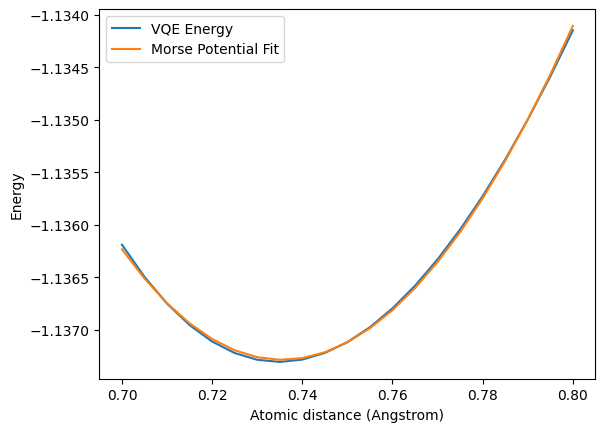

In [124]:
plt.plot(distances, vqe_sv_potential, label="VQE Energy")
plt.plot(distances, vqe_sv_pred, label="Morse Potential Fit")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [125]:
print('c: %f, m: %f, r_eq: %f' %(poptsv[0],poptsv[1], poptsv[2]))

c: 1.137286, m: 0.843012, r_eq: 0.735551


In [126]:
Ha = 4.36e-18
c = poptsv[0] #Ha
m = poptsv[1] #angst^-1
req = poptsv[2] #angst
kb = k_B/Ha

def func(r, tem, amp):
    return amp*np.exp(-(c*(np.exp(-2*m*(r-req))-2*np.exp(-m*(r-req)))+c)/(kb*tem))

In [133]:
poptstat2, pcovstat2 = curve_fit(func, bins[1:], distr_langevin)
distr_pred = [func(i, poptstat2[0], poptstat2[1]) for i in bins]

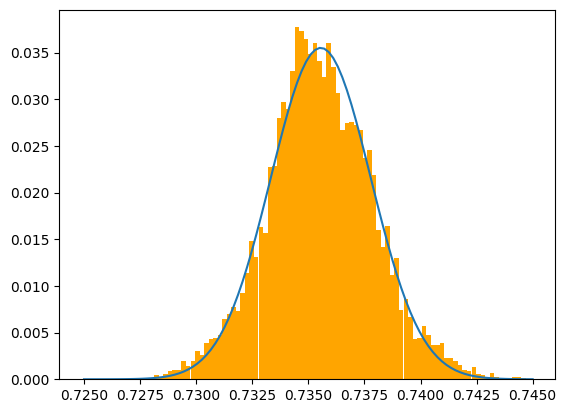

In [143]:
plt.bar(np.array(bins[:-1]), np.array(distr_langevin),width=0.0002, color='orange')
plt.plot(np.array(bins), np.array(distr_pred))
plt.show()

In [141]:
print('T_kin: %f; T_bath: %f'%(k_T/k_B, poptstat2[0]))

T_kin: 10.817055; T_bath: 2.543974


If there is only statistical noise from the forces. The noise would be too small...